# 68 Creating Finite Faults with GemGIS

This notebook illustrates how to create finite faults from a GemPy Model. Here, we will use an elongated version of the Graben Model to later create the finite faults. 

<img src="../images/tutorial68_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gempy as gp
import gemgis as gg
import pandas as pd
import geopandas as gpd

import pyvista as pv

No module named 'osgeo'


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path ='data/68_rotating_gempy_input_data/'
# gg.download_gemgis_data.download_tutorial_data(filename="68_creating_finite_faults_with_gemgis.zip", dirpath=file_path)

## Loading Input Data

In [3]:
interfaces = pd.read_csv(file_path + 'interfaces.csv', delimiter=';')
interfaces.head()

,X,Y,Z,formation
0,200,250,-100,Layer1
1,200,500,-100,Layer1
2,200,750,-100,Layer1
3,200,250,-200,Layer2
4,200,500,-200,Layer2


In [4]:
orientations = pd.read_csv(file_path + 'orientations.csv', delimiter=';')
orientations.head()

,X,Y,Z,formation,dip,azimuth,polarity
0,200,500,-100,Layer1,0,0,1
1,800,500,-100,Layer1,0,0,1
2,500,500,-300,Layer1,0,0,1
3,250,500,-100,Fault1,60,90,1
4,750,500,-100,Fault2,60,270,1


## Creating the GemPy Model

In [5]:
geo_model = gp.create_model('Graben_Model')
geo_model

Graben_Model  2023-08-18 09:11

In [6]:
gp.init_data(geo_model, [0, 1000, -500, 1500, -600, 0], [50,50,50],
             surface_points_df=interfaces,
             orientations_df=orientations,
             default_values=True)

gp.map_stack_to_surfaces(geo_model,
                         {
                          'Fault1': ('Fault1'),
                          'Fault2': ('Fault2'),
                          'Strata1': ('Layer1', 'Layer2', 'Layer3'),                          
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_is_fault(['Fault1', 'Fault2'])
geo_model.set_topography(source='random')
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )
geo_model.surfaces

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
[-120.    0.]
Active grids: ['regular' 'topography']
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                     values
range              2315.17
$C_o$            127619.05
drift equations  [3, 3, 3]


,surface,series,order_surfaces,color,id
3,Fault1,Fault1,1,#527682,1
4,Fault2,Fault2,1,#527682,2
0,Layer1,Strata1,1,#ffbe00,3
1,Layer2,Strata1,2,#728f02,4
2,Layer3,Strata1,3,#443988,5
5,Basement,Strata1,4,#ff3f20,6


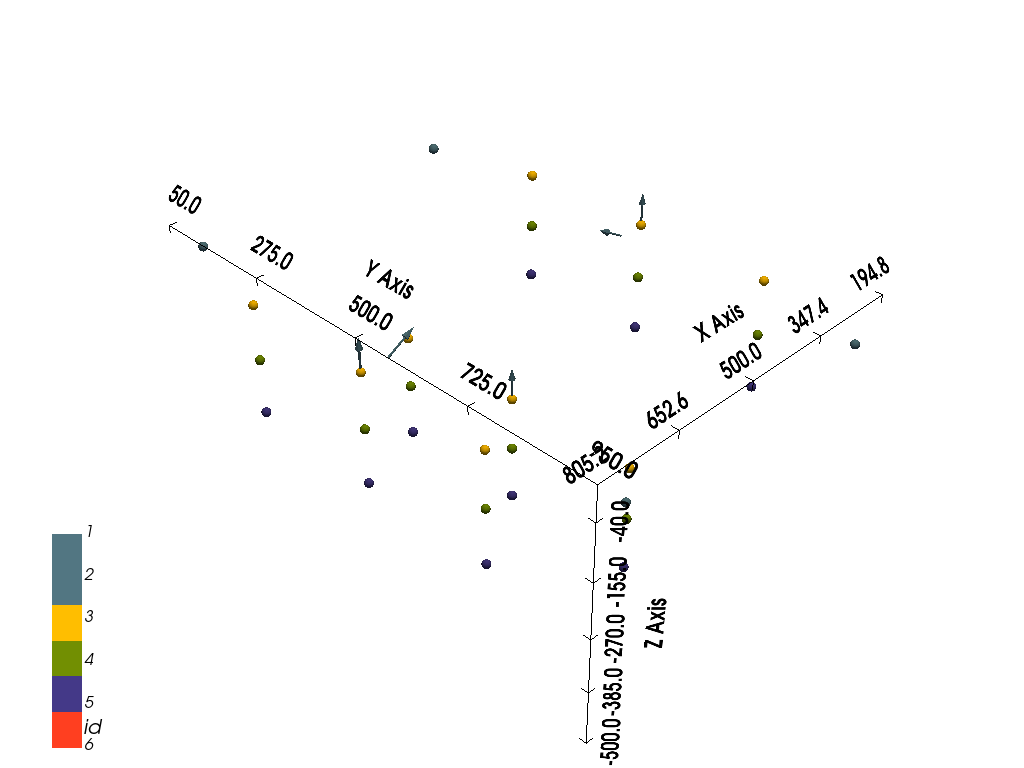

In [7]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

In [8]:
sol = gp.compute_model(geo_model, compute_mesh=True)

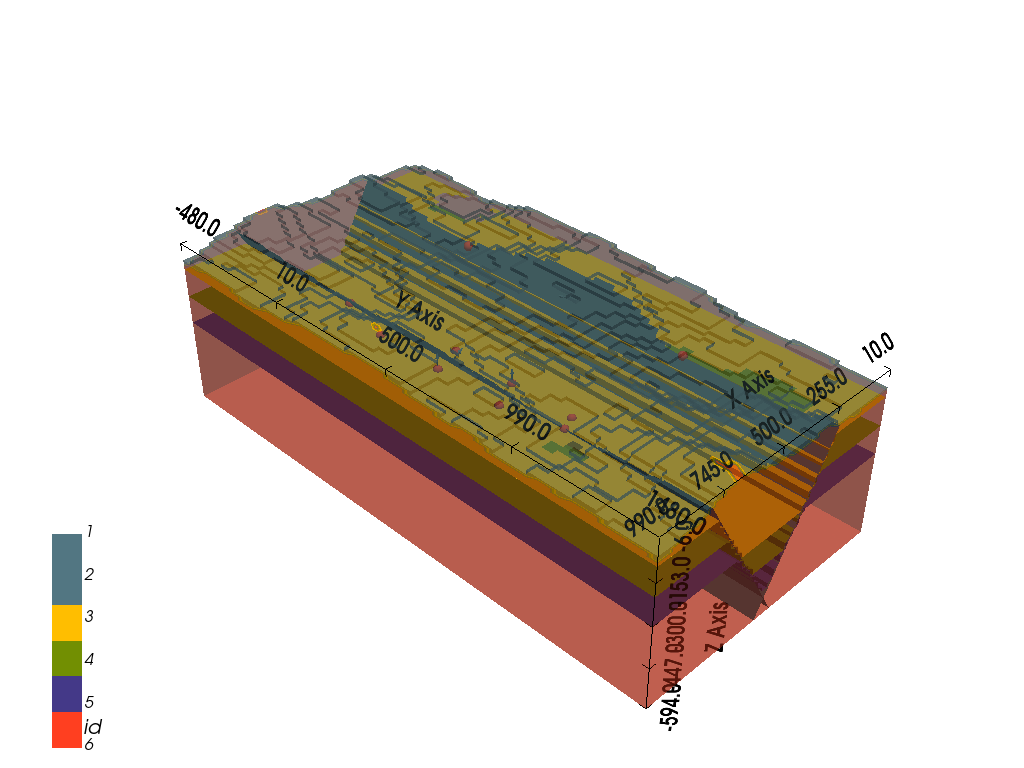

In [9]:
gp.plot_3d(geo_model, notebook=True)

## Creating Finite Faults from GemPy Model

Finite faults will be created during a postprocessing step performed in GemGIS. Here, we are using the function `clip_fault_of_gempy_model(..)` to clip a fault. By default, the fault will be clipped at the first or last interface point (both sides can be chosen). In addition, a buffer along the strike of the fault can be chosen to allow the fault to extend beyond the last interface point if wished. 

Here, we are choosing to clip the fault on both ends. For the one end, we would like to have a 250 m buffer so that the fault extends beyond the first point. For the last point, we do not want to have a buffer.

In [11]:
mesh = gg.postprocessing.clip_fault_of_gempy_model(geo_model,fault='Fault1', 
                                                   which='both', 
                                                   buffer_first=250, 
                                                   buffer_last=0)
mesh

{'Fault1': [PolyData (0x216abcb9fc0)
    N Cells:    3545
    N Points:   1896
    N Strips:   0
    X Bounds:   2.027e+02, 5.352e+02
    Y Bounds:   -2.000e+02, 9.500e+02
    Z Bounds:   -5.940e+02, -1.800e+01
    N Arrays:   1,
  '#527682']}

In [12]:
fault_polydata = pv.PolyData(interfaces[interfaces['formation']=='Fault1'][['X', 'Y', 'Z']].values)
fault_polydata

PolyData,Information
N Cells,2
N Points,2
N Strips,0
X Bounds,"2.500e+02, 2.500e+02"
Y Bounds,"5.000e+01, 9.500e+02"
Z Bounds,"-1.000e+02, -1.000e+02"
N Arrays,0


In [13]:
mesh1 = gg.visualization.create_depth_maps_from_gempy(geo_model, surfaces='Fault1')
mesh1

{'Fault1': [PolyData (0x216abcb9780)
    N Cells:    5786
    N Points:   3015
    N Strips:   0
    X Bounds:   2.027e+02, 5.352e+02
    Y Bounds:   -4.800e+02, 1.480e+03
    Z Bounds:   -5.940e+02, -1.800e+01
    N Arrays:   1,
  '#527682']}

## Plotting the Result

Plotting the result, we can see the interface points of the fault (red spheres), the original extent of the fault modeled by GemPy in gray and the clipped fault (finite fault) with a buffer on one side in red.

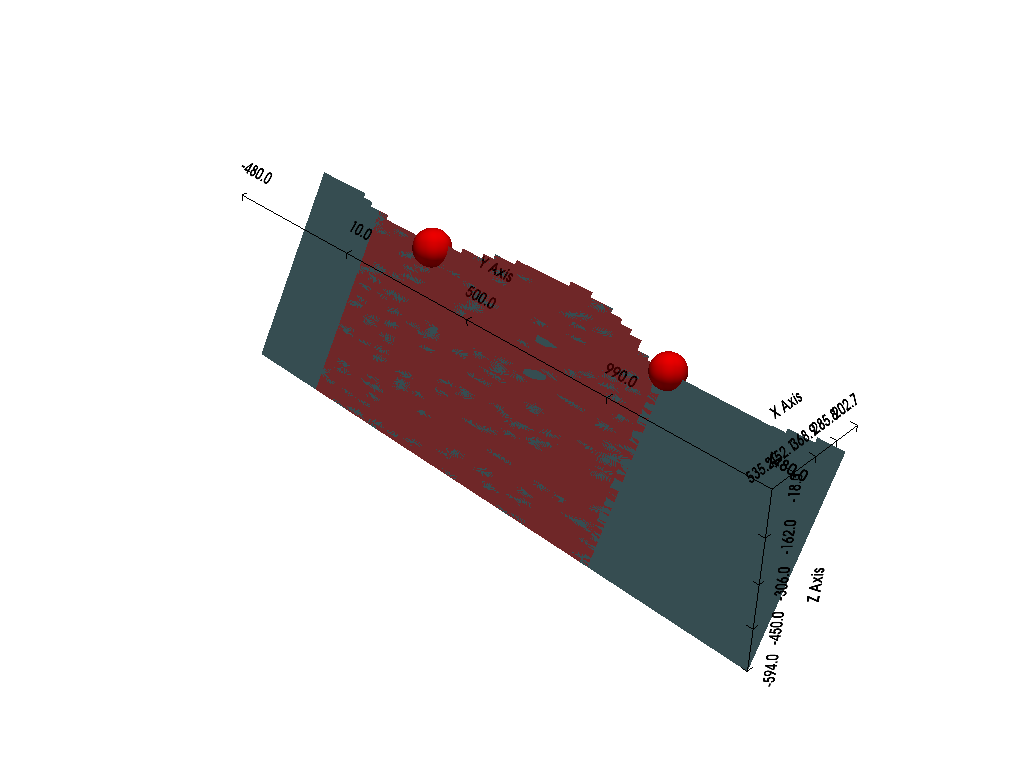

In [14]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh['Fault1'][0], color='red', opacity=0.5)
p.add_mesh(mesh1['Fault1'][0], color=mesh1['Fault1'][1])

p.add_mesh(fault_polydata, color='red', point_size=40, render_points_as_spheres=True)

p.set_background('white')
p.set_scale(1,1,1)
p.show_bounds(color='black', font_size=12)

p.show()